In [ ]:
! pip install scipy numpy matplotlib jupyter ipympl sympy mediapy

In [1]:
import numpy as np
from scipy.optimize import NonlinearConstraint, minimize, Bounds, OptimizeResult
import matplotlib.pyplot as plt
from PIL import Image

## Curve fitting

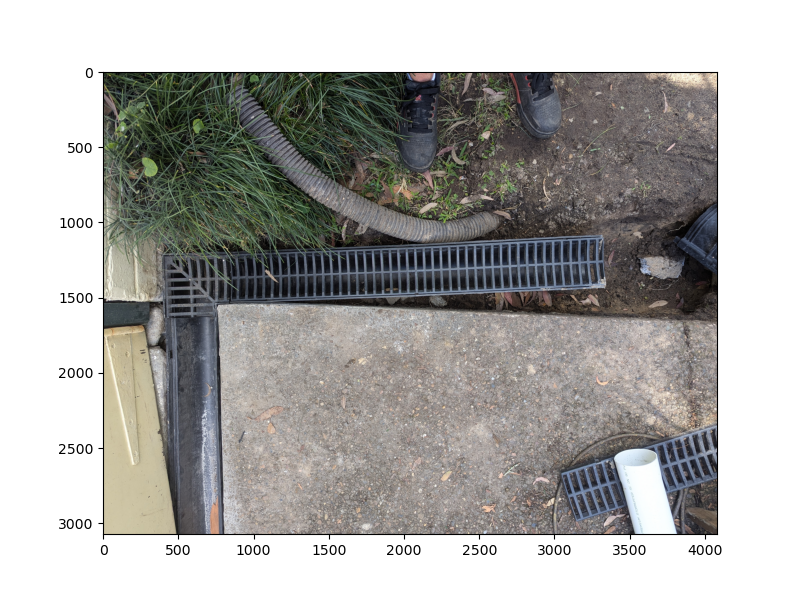

In [2]:
# Interactive plot to determine curve points
# Use the rectangle selection tool to zoom, and get the coordinates from hovering the cursor
%matplotlib widget
image = np.array(Image.open("gutter-photo.jpg"))
# image = np.rot90(image, axes=(0,1), k=2)

fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(image)

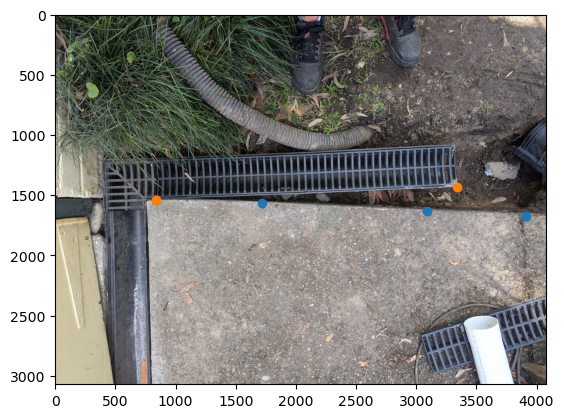

In [3]:
%matplotlib inline
plt.close()
points = np.array([[ 840, 1530],
       [1722, 1508],
       [3090, 1442],
       [3910, 1400]])

# imshow y axis is flipped, so you'll have to uncomment this line if you've read coordinates from it
# points = image.shape[0] - points

# points = np.array([[ 840, 1530],
#        [1722, 1442],
#        [3090, 1600],
#        [3910, 1500]])
orig_line = np.array([[ 840, 1530], [3340, 1641]])
init_grad = (orig_line[1][1]-orig_line[0][1])/(orig_line[1][0]-orig_line[0][0])

plt.imshow(image)
plt.plot(points[:,0], image.shape[0]-points[:,1], 'o')
plt.plot(orig_line[:,0], image.shape[0]-orig_line[:,1], 'o')
plt.show()

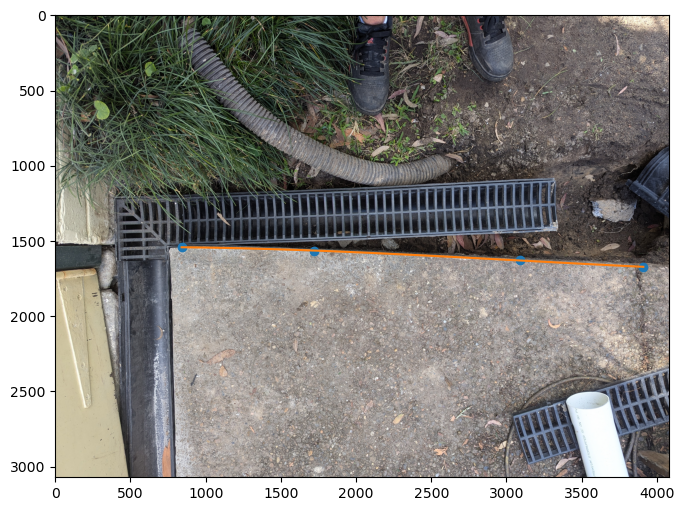

In [5]:
cubic_interpolation_model = np.polynomial.Polynomial.fit(points[:,0], points[:,1],3)

curve_x = np.linspace(points[0,0], points[-1,0], 100)
curve_y = cubic_interpolation_model(curve_x)
curve = cubic_interpolation_model.convert().coef

fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(image)
plt.plot(points[:,0], image.shape[0]-points[:,1], 'o')
plt.plot(curve_x, image.shape[0]-curve_y)

## Objective function in sympy

Our objective to minimise is the integral between the line segments and the curve

In [6]:
import sympy

x, y, x0, y0, x1, y1, a, b, c, d, D = sympy.symbols('x y x0 y0 x1 y1 a b c d D')
line = (y1-y0)/(x1-x0)*(x-x0) + y0
poly = a*x**3+b*x**2+c*x+d
f = line - poly
display(f)

-a*x**3 - b*x**2 - c*x - d + y0 + (x - x0)*(-y0 + y1)/(-x0 + x1)

In [7]:
# Integral from x0 to x1 (objective function for a single segment)
F0 = sympy.integrate(f, (x, x0, x1))
display(F0)

a*x0**4/4 - a*x1**4/4 + b*x0**3/3 - b*x1**3/3 - x0**2*(-c*x0 + c*x1 + y0 - y1)/(2*x0 - 2*x1) - x0*(-d*x0 + d*x1 + x0*y1 - x1*y0)/(x0 - x1) + x1**2*(-c*x0 + c*x1 + y0 - y1)/(2*x0 - 2*x1) + x1*(-d*x0 + d*x1 + x0*y1 - x1*y0)/(x0 - x1)

In [8]:
def multi_seg_sum_from_expression(expr, vars, k):
    """
    Given an expression for a single line segment, return the summation of the expression over all k+1 segments
    E.g. if k=1, we have:
    - two line segments
    - variables x0,y0x1,y1,x2,y2

    Args:
    - expr: the symbolic expression for a single segment, in terms of x0,y0,x1,y1
    - vars: the variables for which to compute the Jacobian and Hessian (i.e. the columns of the jacobian)
    - k: the number of line segment joints (i.e. num line segments - 1)
    - x0_val, y0_val: the values for the fixed starting point
    Returns:
    - an evaluation function
    - a jacobian evaluation function
    - a hessian evaluation function

    The evaluation functions take a single argument, the current state vector:
    x1,y1,x2,y2...
    """
    # Form the symbolic expression in terms of x0,y0...x_k+1, y_k+1
    multi_seg_expr = expr
    for i in range(1,k+1):
        multi_seg_expr += expr.subs([('x0', f"x{i}"), ('y0', f"y{i}"), ('x1', f"x{i+1}"), ('y1', f"y{i+1}")], simultaneous=True)

    # Compute the analytical jacobian and hessian (so easy!)
    multi_seg_jac = sympy.Matrix([multi_seg_expr]).jacobian(vars)
    multi_seg_hess = sympy.hessian(multi_seg_expr, vars)
    
    def multi_seg_f(x):
        nonlocal multi_seg_expr
        expr = multi_seg_expr.subs([('a',curve[3]),('b',curve[2]),('c',curve[1]),('d',curve[0])])
        # Sub the rest of the terms
        for i in range(k+1):
            expr = expr.subs([(f"x{i}", x[2*(i)]),(f"y{i}", x[2*(i)+1]),(f"x{i+1}", x[2*(i+1)]),(f"y{i+1}", x[2*(i+1)+1])])
        return np.array(expr, dtype=float)

    def multi_seg_J(x):
        nonlocal multi_seg_jac
        expr = multi_seg_jac.subs([('a',curve[3]),('b',curve[2]),('c',curve[1]),('d',curve[0])])
        for i in range(k+1):
            expr = expr.subs([(f"x{i}", x[2*(i)]),(f"y{i}", x[2*(i)+1]),(f"x{i+1}", x[2*(i+1)]),(f"y{i+1}", x[2*(i+1)+1])])
        return np.array(expr, dtype=float)[0]

    def multi_seg_H(x, v=None):
        nonlocal multi_seg_hess
        expr = multi_seg_hess.subs([('a',curve[3]),('b',curve[2]),('c',curve[1]),('d',curve[0])])
        for i in range(k+1):
            expr = expr.subs([(f"x{i}", x[2*(i)]),(f"y{i}", x[2*(i)+1]),(f"x{i+1}", x[2*(i+1)]),(f"y{i+1}", x[2*(i+1)+1])])
        return np.array(expr, dtype=float)
    
    return multi_seg_f, multi_seg_J, multi_seg_H

In [9]:
# Problem parameters

# Number of cuts
k = 1
D_val = np.sqrt((orig_line[1][0]-points[0][0])**2 + (orig_line[1][1]-points[0][1])**2)
x0_val, y0_val = points[0][0], points[0][1]


init_x: [ 840.         1530.         2091.23149337 1585.55467831 3342.46298674
 1641.10935661]
vars: ['x0', 'y0', 'x1', 'y1', 'x2', 'y2']
init cost: 243628.21929850848


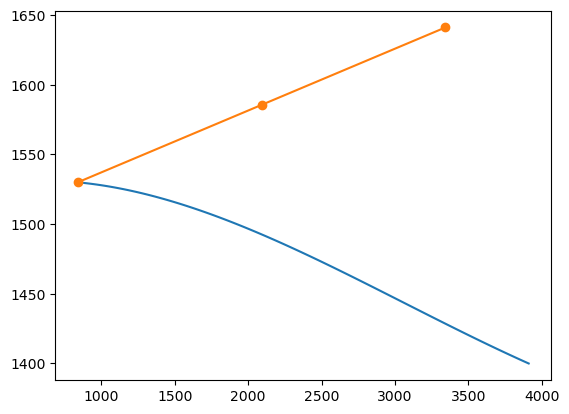

In [10]:
# Equation variables, a vector of x1,y1,x2,y2...xk+1,yk+1
vars = []
for i in range(k+2):
    vars += [f"x{i}",f"y{i}"]

# Get evaluation functions for the objective function over all segments, as well as Jacobian
multi_seg_obj_funs = multi_seg_sum_from_expression(F0, vars, k)

# Initialise points to flat above curve, equally spaced
init_x = []
seglen = D_val/(k+1)

for i in range(k+2):
    init_x += [points[0][0]+D_val/(k+1)*i]
    init_x += [points[0][1] + i*seglen*init_grad] #[poly.subs([('a',curve[3]),('b',curve[2]),('c',curve[1]),('d',curve[0]),('x', init_x[-1])])+200]
init_x = np.array(init_x)
print("init_x:", init_x)
print("vars:", vars)
print("init cost:", multi_seg_obj_funs[0](init_x))
# Plot init points
%matplotlib inline
plt.close()
plt.plot(curve_x, curve_y)
plt.plot(np.hstack((init_x[::2,])), np.hstack((init_x[1::2,])), '-o')
plt.show()

### Constraints

Segment 0 min_dist: -4.44755343664838e-13
Segment 0 y1 dist: 34.2623722606927
Segment 1 min_dist: -12.9856385424212
Segment 1 y1 dist: -12.9856385424214


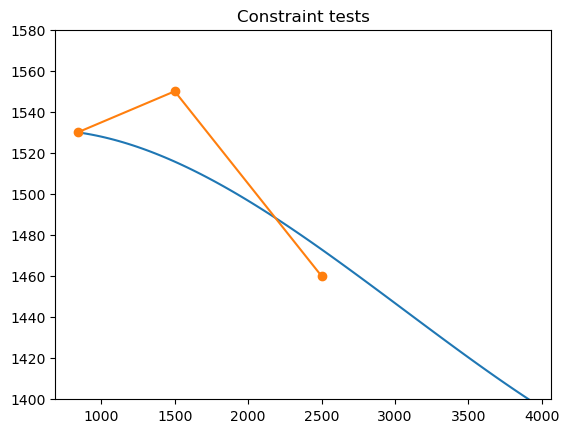

In [29]:
def above_curve_constraint(x,i):
    """
    Minimum vertical distance from line to curve for segment i
    Negative if line is below curve
    Does an iterative optimisation to find
    """

    x0 = x[i*2]
    y0 = x[(i*2)+1]
    
    x1 = x[(i+1)*2]
    y1 = x[(i+1)*2+1]

    dist = (line-poly).subs([('x0',x0),('y0',y0),('x1', x1),('y1', y1),(a,curve[3]),(b,curve[2]),(c,curve[1]),(d,curve[0])])
    dist_diff = dist.diff('x') # we have the analytical derivative so may as well use it
    # init = min(dist.subs([('x', x0)]), dist.subs([('x', x1)]))
    init = dist.subs([('x', (x0+x1)/2)]) # initial guess at midpoint
    min_dist = minimize(lambda p: np.array(dist.subs([('x', p[0])])), [init], bounds=Bounds(x0, x1), jac=lambda p: np.array(dist_diff.subs([('x', p[0])])), tol=1e-8)
    # print(min_dist)
    return min_dist.fun

def y1_above_curve_constraint(x,i):
    """
    Vertical distance from end (right point, 1) of line segment to curve, for segment i
    """
    
    x0 = x[i*2]
    y0 = x[i*2+1]
    x1 = x[(i+1)*2]
    y1 = x[((i+1)*2)+1]
    dist = (line-poly).subs([('x', x1),('x0',x0),('y0',y0),('x1', x1),('y1', y1),(a,curve[3]),(b,curve[2]),(c,curve[1]),(d,curve[0])])
    return dist

 
# Test the segment constraints w/ visualisation
# Check that the printed values are as expected for each segment
x_test = np.array([init_x[0], init_x[1], 1500,1550, 2500, 1460])
for i in range(len(x_test)//2-1):
    print("Segment",i,"min_dist:", above_curve_constraint(x_test, i))
    print("Segment",i,"y1 dist:", y1_above_curve_constraint(x_test, i))

%matplotlib inline
plt.close()
plt.plot(curve_x, curve_y)
plt.plot(np.hstack((x_test[::2,])), np.hstack((x_test[1::2,])), '-o')
plt.title("Constraint tests")
plt.gca().set_ylim([1400, 1580])

plt.show()


In [ ]:
# Total distance constraint is the sum of lengths of all segments
# Individual segment expression:
cons_d_expr=((x1-x0)**2+(y1-y0)**2)**0.5
d_cons_funs = multi_seg_sum_from_expression(cons_d_expr, vars, k)
print("Current D:", d_cons_funs[0](init_x))

# Optional offset of the line from the curve, to be on the safe side
y_offs = 0

constraints = []

for i in range(1,k+1):
    constraints.append({'type': 'ineq',
                        'fun': lambda x, i=i: above_curve_constraint(x,i)-y_offs})
for i in range(k+1):
    constraints.append({'type': 'ineq',
                        'fun': lambda x, i=i: y1_above_curve_constraint(x,i)-y_offs})

# Equality constraints are set to equal 0, so subtract given D_val to get total distance equal to it
constraints.append({'type': 'eq',
                    'fun': lambda x: d_cons_funs[0](x) - D_val,
                    'jac': d_cons_funs[1]})

# x0 constraint
constraints.append({'type': 'eq',
                    'fun': lambda x: x[0]-x0_val,
                    'jac': lambda x: np.array([1, 0] + [0]*(k+1)*2)}) # does just as well without the jacobian as it's simple, but left in for completeness

# y0 constraint

constraints.append({'type': 'eq',
                    'fun': lambda x: x[1] - y0_val - y_offs,
                    'jac': lambda x: np.array([0, 1] + [0]*(k+1)*2)})

# Alternate y0 constraint as upper bound
# constraints.append({'type': 'ineq',
#                     'fun': lambda x: -(x[1]-y0_val-y_offs)+1e-4,
#                     'jac': lambda x: np.array([0, -1] + [0]*(k+1)*2)})

# init gradient constraint
constraints.append({'type': 'eq',
                    'fun': lambda x: (x[3]-y0_val)/(x[2]-x0_val)-init_grad})

# Alternate init gradient constraint using x0 and y0 variables doesn't seem to do quite as well as just using the constants
# init_grad_expr = (y1-y0)/(x1-x0)
# init_grad_cons_funs = multi_seg_sum_from_expression(init_grad_expr, vars, 0)
# constraints.append({'type': 'eq',
#                     'fun': lambda x: init_grad_cons_funs[0](x)-init_grad})

constraints

Current D: 2504.9284


[{'type': 'ineq', 'fun': <function __main__.<lambda>(x, i=1)>},
 {'type': 'ineq', 'fun': <function __main__.<lambda>(x, i=0)>},
 {'type': 'ineq', 'fun': <function __main__.<lambda>(x, i=1)>},
 {'type': 'eq',
  'fun': <function __main__.<lambda>(x)>,
  'jac': <function __main__.multi_seg_sum_from_expression.<locals>.multi_seg_J(x)>},
 {'type': 'eq',
  'fun': <function __main__.<lambda>(x)>,
  'jac': <function __main__.<lambda>(x)>},
 {'type': 'eq',
  'fun': <function __main__.<lambda>(x)>,
  'jac': <function __main__.<lambda>(x)>},
 {'type': 'eq', 'fun': <function __main__.<lambda>(x)>}]

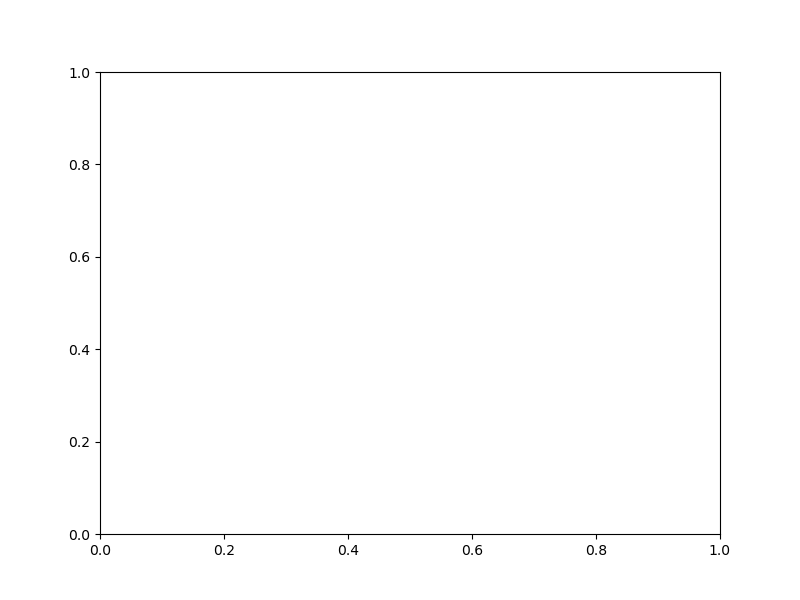

In [15]:
# Set up blank interactive window
%matplotlib widget
plt.close()
fig, ax = plt.subplots(figsize=(8, 6))

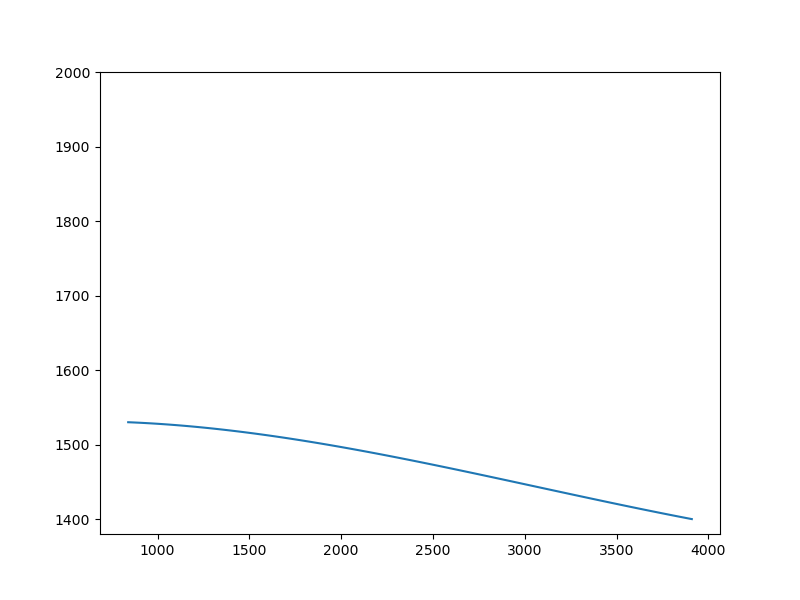

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8857.10737654334
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 13


In [16]:
frames = []
step = 0

# Solve and plot
ax.clear()
ax.plot(curve_x, curve_y)
ax.set_ylim([1380, 2000])
plt.show()
plt_line, = ax.plot(init_x[::2,], init_x[1::2,], '-o')
def plot_cb(curr_x):
    global curr_res
    curr_res = curr_x
    global step
    plt_line.set_data(curr_x[::2],curr_x[1::2])
    ax.set_title(f"Iteration {step}")
    fig.canvas.draw()
    curr_plot = np.array(fig.canvas.buffer_rgba(), dtype=np.uint8)[:,:,:-1]
    frames.append(curr_plot)
    step += 1

plot_cb(init_x)

res = minimize(multi_seg_obj_funs[0], init_x, method='SLSQP', jac=multi_seg_obj_funs[1],
               constraints=constraints, options={'ftol': 1e-4, 'disp': True}, callback=plot_cb)

In [ ]:
# Convert the convergence to a video if desires
import mediapy as media
media.show_video(frames, fps=2)
# media.write_video(f'slsqp-k{k}.mp4', frames, fps=2)


In [17]:
# View the result coordinates
res.x

array([ 840.        , 1530.        , 1075.82942302, 1540.47082638,
       3339.73291841, 1434.0965815 ])

## Plot the result

In [18]:
# Angles between line segments
def get_angles(x):
    angles = []
    for i in range(k):
        x0,y0 = x[2*i], x[2*i+1]
        x1,y1 = x[2*(i+1)], x[2*(i+1)+1]
        x2,y2 = x[2*(i+2)], x[2*(i+2)+1]
        a1 = np.arctan2(y1-y0,x1-x0)
        a2 = np.arctan2(y2-y1,x2-x1)
        ang_deg = (a1-a2) / np.pi * 180
        angles.append(ang_deg)
    return angles

angles = get_angles(res.x)

In [22]:
# Organise angles, points, distances into a dictionary
final_points = {'x': res.x[::2], 'y': res.x[1::2], 'ang': angles, 'd': []}

for i in range(k+1):
    final_points['d'].append(((final_points['x'][i+1] - final_points['x'][i])**2 + (final_points['y'][i+1] - final_points['y'][i])**2)**0.5)

final_points

{'x': array([ 840.        , 1075.82942302, 3339.73291841]),
 'y': array([1530.        , 1540.47082638, 1434.0965815 ]),
 'ang': [np.float64(5.232446437021494)],
 'd': [np.float64(236.0617609141068), np.float64(2266.401225825194)]}

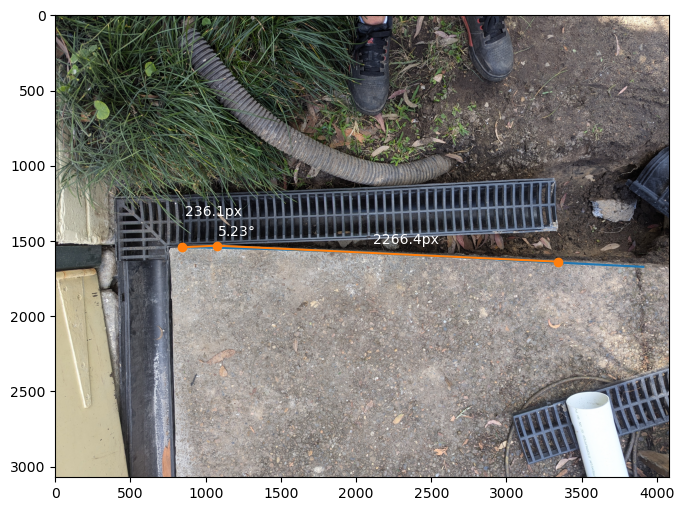

In [ ]:
%matplotlib inline
plt.close()
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.imshow(image)
plt.plot(curve_x, image.shape[0]-curve_y)

plt.plot(final_points['x'], image.shape[0]-final_points['y'], '-o')  # 'o' for circles as markers

# plot lengths
for i in range(k+1):
    plt.annotate(f'{final_points['d'][i]:.1f}px',  # The text to display
                 xy=((final_points['x'][i]+final_points['x'][i+1])/2, image.shape[0]-(final_points['y'][i]+final_points['y'][i+1])/2),
                 xytext=(-10, 5 if final_points['d'][i] > 350 else 20),    # Offset from the point (in points)
                 textcoords='offset points', # How to interpret xytext
                 ha='left',       # Horizontal alignment
                 va='bottom',
                 color='w')     # Vertical alignment

# plot angles
for i in range(k):
    plt.annotate(f'{final_points['ang'][i]:.2f}$\\degree$',
                 xy=(final_points['x'][i+1], image.shape[0]-final_points['y'][i+1]),
                 xytext=(0, 5),    # Offset from the point (in points)
                 textcoords='offset points', # How to interpret xytext
                 ha='left',       # Horizontal alignment
                 va='bottom',
                 color='w')     # Vertical alignment

In [24]:
# This is the length of the gutter in pixels - compare to real life and convert pixel distances to metres
D_val

np.float64(2502.4629867392646)

## Appendix
### Alternative solvers

In [25]:
from scipy.optimize import LinearConstraint
# Total distance constraint is the sum of lengths of all segments
# Individual segment expression:
cons_d_expr=((x1-x0)**2+(y1-y0)**2)**0.5
d_cons_funs = multi_seg_sum_from_expression(cons_d_expr, vars, k)
print("Current D:", d_cons_funs[0](init_x))

y_offs = 0

constraints = []

# 
for i in range(1,k+1):
    constraints.append(NonlinearConstraint(lambda x, i=i: np.array(above_curve_constraint(x,i)-y_offs, dtype=float), 0, np.inf))
    
for i in range(k+1):
    constraints.append(NonlinearConstraint(lambda x, i=i: np.array(y1_above_curve_constraint(x,i)-y_offs, dtype=float), 0, np.inf))

# D constraint
constraints.append(NonlinearConstraint(lambda x: np.array(d_cons_funs[0](x), dtype=float) - D_val, 0, 0, jac=d_cons_funs[1], hess=d_cons_funs[2]))

# x0 constraint
A = np.zeros(( (k+2)*2,(k+2)*2 ))
A[0,0] = 1 # x0
A[1,1] = 1 # y0
print(A.shape)
constraints.append(LinearConstraint(A, [x0_val, y0_val] + [0]*(k+1)*2, [x0_val, y0_val] + [0]*(k+1)*2))


# init gradient constraint
init_grad = (orig_line[1][1]-orig_line[0][1])/(orig_line[1][0]-orig_line[0][0])
constraints.append(NonlinearConstraint(lambda x: np.array((x[3]-y0_val)/(x[2]-x0_val)-init_grad, dtype=float), 0, 0))
# y0 constraint and above_curve_constraint don't play well together

constraints


Current D: 2504.9284
(6, 6)


In [26]:
frames = []
step = 0

# Solve and plot
ax.clear()
ax.plot(curve_x, curve_y)
ax.set_ylim([1380, 1600])
plt.show()
plt_line, = ax.plot(init_x[::2,], init_x[1::2,], '-o')
def plot_cb(intermediate_result):
    if isinstance(intermediate_result, OptimizeResult):
        intermediate_result = intermediate_result.x
    global curr_res
    curr_res = intermediate_result
    global step
    # print(intermediate_result)
    plt_line.set_data(intermediate_result[::2],intermediate_result[1::2])
    ax.set_title(f"Iteration {step}")
    fig.canvas.draw()
    curr_plot = np.array(fig.canvas.buffer_rgba(), dtype=np.uint8)[:,:,:-1]
    frames.append(curr_plot)
    step += 1


plot_cb(init_x)
res = minimize(multi_seg_obj_funs[0], init_x, method='trust-constr', jac=multi_seg_obj_funs[1],# hess=multi_seg_obj_funs[2],
               constraints=constraints,
               options={'verbose': 1, 'initial_constr_penalty':2, 'initial_tr_radius':2}, callback=plot_cb)
# res = minimize(multi_seg_obj_funs[0], init_x, method='COBYQA', jac=multi_seg_obj_funs[1], hess=multi_seg_obj_funs[2],
#                constraints=constraints,
#                options={'verbose': 1}, callback=plot_cb)

/Users/Eugene/miniconda3/envs/constrained_optim/lib/python3.12/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:81: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
/Users/Eugene/miniconda3/envs/constrained_optim/lib/python3.12/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
/Users/Eugene/miniconda3/envs/constrained_optim/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 124, function evaluations: 4, CG iterations: 0, optimality: 6.16e+02, constraint violation: 2.78e-17, execution time:  4.6 s.
